# Preparativos

In [505]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../scripts")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils

In [4]:
plt.rcParams["figure.figsize"] = (14,4)

##### Carga de datos

In [5]:
data = pd.read_csv("../data/base_limpia.csv", parse_dates=["tiempo", "fecha pedido", "fecha liq"])

In [6]:
data.head()

,tiempo,nro factura,cliente,categoria,tipo negocio,localidad,direccion,plaza/campaña,producto,nro pedido,...,u pedidas,kg pedidos,fecha liq,u entregadas,kg entregados,importe bruto,importe factura,sucursal,longitud,latitud
0,2017-05-29,93315173,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2736812,...,1,1.250,2017-05-29,1,1.250,231.70,12421.88,santa fe,-60.691979,-31.602638
1,2017-06-14,93368453,200008870,a5,mayorista,santa fe,av del valle 7199,plaza,90746,2765668,...,1,1.250,2017-06-14,1,1.250,231.70,19944.84,santa fe,-60.691979,-31.602638
2,2017-02-21,93074208,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90740,2546672,...,2,1.464,2017-02-21,2,1.464,324.96,24534.07,santa fe,-60.686356,-31.620964
3,2017-05-11,93270490,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2702464,...,1,1.250,2017-05-11,1,1.250,231.70,27204.63,santa fe,-60.686356,-31.620964
4,2017-05-24,93309184,200008889,a3,supermercado,santa fe,gral.paz 5374,plaza,90746,2732609,...,1,1.250,2017-05-24,1,1.250,231.70,16573.12,santa fe,-60.686356,-31.620964


# Pronóstico por producto

Ahora armamos la tabla con los pedidos por día por producto.

In [7]:
u_producto = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns="producto", 
    aggfunc="sum").asfreq("D")

In [8]:
u_producto.head()

producto,16034,16061,16062,16070,16071,16075,16076,16077,16080,16081,...,44151,44152,44154,44155,44157,44158,90739,90740,90745,90746
tiempo,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,7.0,1.0,25.0,11.0,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,4.0,1.0,NaN,NaN
2017-01-03,NaN,21.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,NaN,NaN
2017-01-04,NaN,NaN,NaN,8.0,4.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN
2017-01-05,NaN,3.0,NaN,6.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.0,NaN,1.0,NaN,1.0,NaN,NaN
2017-01-06,NaN,NaN,2.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Falta la fecha 01/01/2017. Por una cuestión de consistencia la agregamos al indice, aunque las observaciones sean todas NA.

In [9]:
u_producto = u_producto.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

Graficamos las series temporales de cada uno de los productos.

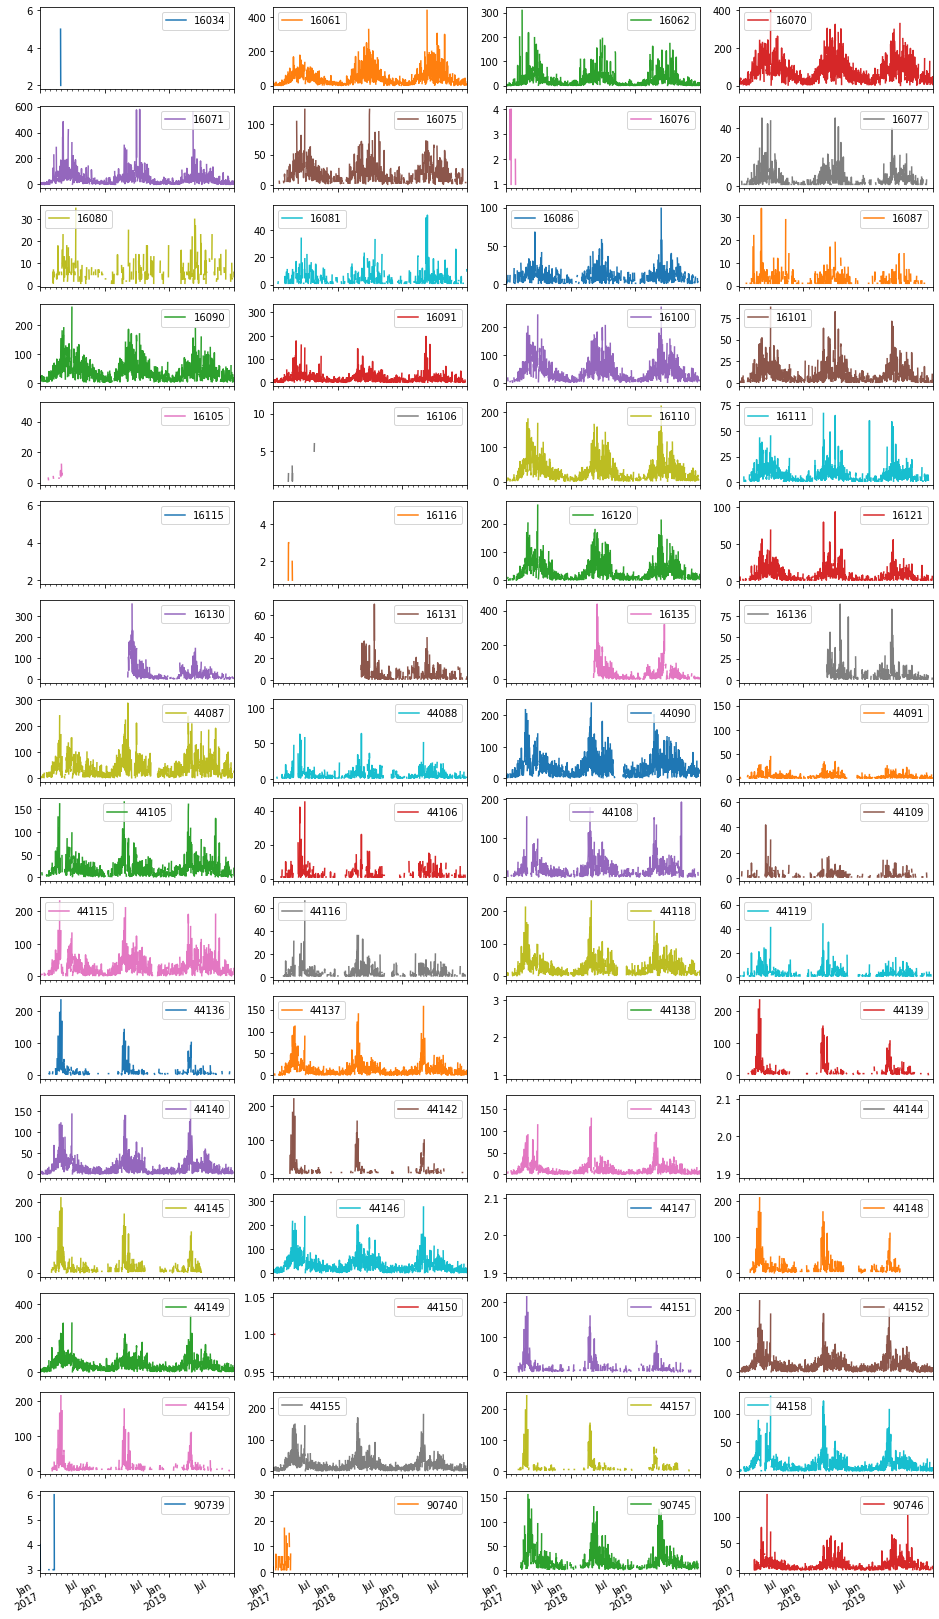

In [10]:
utils.plot_grid(u_producto, n_cols=4, figsize=(16,32))

Hay productos que presentan muy pocos pedidos durante este período como para hacer un pronóstico. Podemos calcular la cantidad de observaciones no nulas sobre el total de observaciones para obtener una representación de la proporción de "información" disponible en cada serie, como graficamos a continuación.

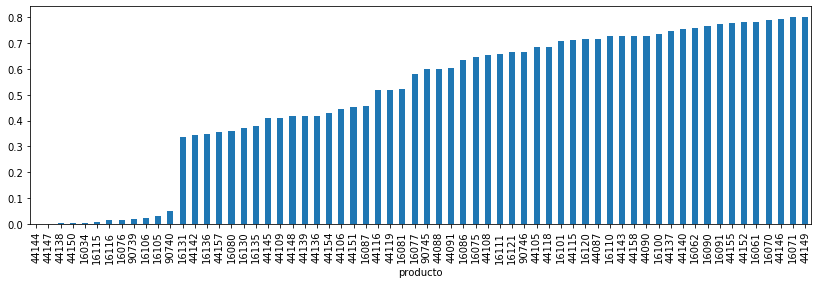

In [11]:
utils.get_amount_info(u_producto).plot(kind="bar")

Podemos asignar un umbral T, a partir del cual consideramos que la serie es apta para ser pronosticada. Para los ejemplos que siguen vamos a elegir T=0.5 y vamos a quedarnos con 6 series.

In [506]:
u_producto_forecastable = utils.get_forecastables(u_producto, T=0.5, N=6)

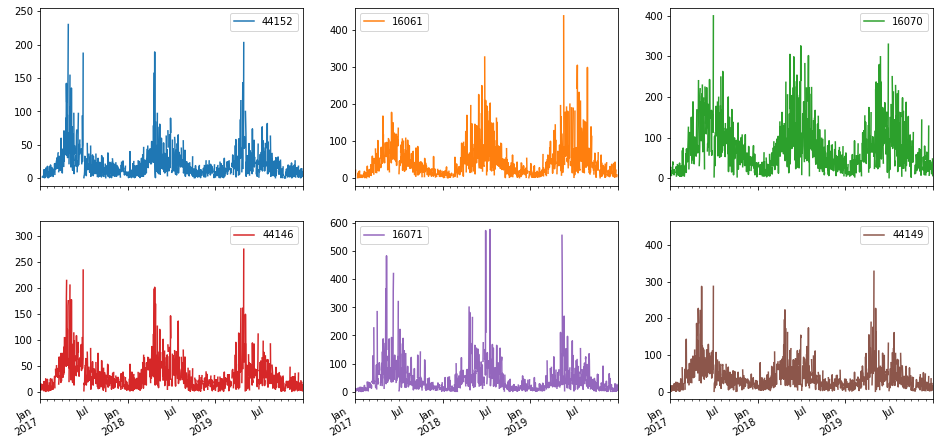

In [507]:
utils.plot_grid(u_producto_forecastable, n_cols=3, figsize=(16, 8))

Tomamos los dos primeros años como conjunto de entrenamiento y el último como prueba.

In [510]:
train_orig, test_orig = u_producto_forecastable[:"2018-12-31"].copy(), u_producto_forecastable["2019-01-01":].copy()

Cargamos un indicador económico, obtenido a partir del precio de la nafta, para usar como regresor en algunos de los ejemplos.

In [509]:
indicador_orig = pd.read_csv("../data/indicador_económico.csv", parse_dates=["fecha"]).set_index("fecha")

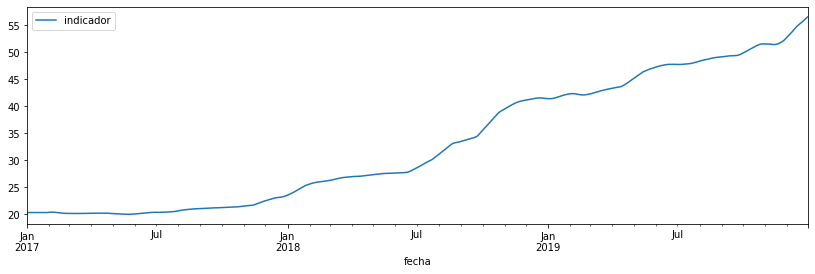

In [513]:
indicador_orig.plot()

## Pronóstico diario

In [329]:
from forecaster import ProphetForecaster

In [338]:
train = train_orig.copy()
test = test_orig.copy()

Realizamos un pronóstico diario de cada una de las series, un año hacia adelante, con intervalos de confianza del 80%.

In [339]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


El resultado es un DataFrame con la predicción y cotas inferiores y superiores para cada producto, abarcando el período de entrenamiento y el período de pronóstico. A continuación mostramos algunas filas.

In [511]:
fcst.head()

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  5.386853   1.670065  16.935038  2.229475   0.746073   7.220748   
2017-01-03  5.406998   1.537410  15.065371       NaN        NaN        NaN   
2017-01-04       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-05  5.441283   1.596328  16.549595       NaN        NaN        NaN   
2017-01-06       NaN        NaN        NaN  2.306941   0.778068   7.338176   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
ds                                                     ...              
2017-01-02  14.953977   4.131406  41.725148  5.567765  ...        NaN   
2017-01-03  14.656313   4.702902  39.560691  5.496262  ...        NaN   
2017-01-04  14.414836   4.613350  39.159996  5.432328  ...        NaN   
2017-01-05  14.227067   4.189576  38.322650  5.375307  ...        NaN   
2017-01-06  14.089813   4.229136  40.495064       NaN  ...        NaN   

                                              44152                        \
            santa fe                       santa fe                         
                yhat yhat_lower yhat_upper     yhat yhat_lower yhat_upper   
ds                                                                          
2017-01-02  7.859500   1.929941  24.476286      NaN        NaN        NaN   
2017-01-03  7.707466   1.893666  25.862422      NaN        NaN        NaN   
2017-01-04  7.570713   2.008835  22.915488      NaN        NaN        NaN   
2017-01-05  7.449867   1.778374  23.607467      NaN        NaN        NaN   
2017-01-06  7.345328   1.847968  22.844806      NaN        NaN        NaN   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
ds                                          
2017-01-02  3.829905   1.250009  12.196536  
2017-01-03       NaN        NaN        NaN  
2017-01-04  3.911377   1.356889  11.367460  
2017-01-05  3.942978   1.263569  11.802553  
2017-01-06       NaN        NaN        NaN  

[5 rows x 36 columns]

Graficamos el resultado.

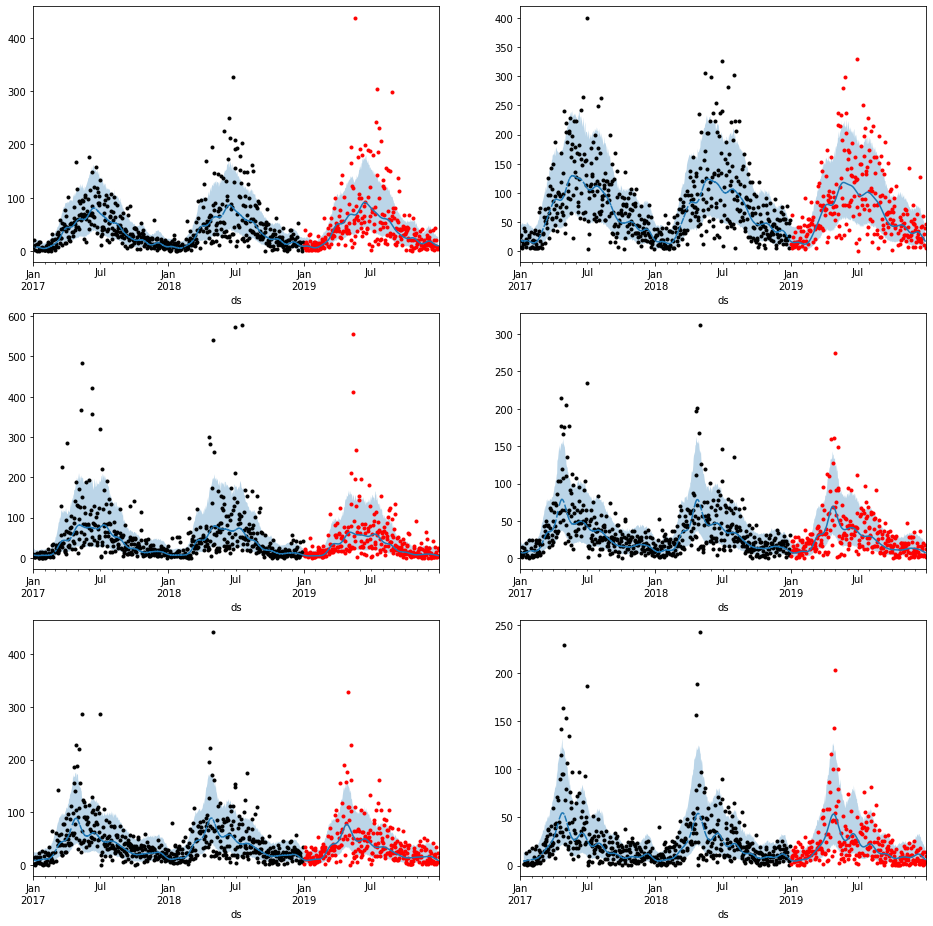

In [341]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

Calculamos el error del pronóstico respecto al conjunto de prueba y usamos eso para determinar el error medio absoluto (MAE) y el error porcentual medio absoluto (MAPE), para cada producto.

In [342]:
error = utils.calculate_error(fcst, test)

In [343]:
mae = error.abs().mean()
mae

16061    26.650334
16070    34.349628
16071    23.811010
44146    15.362168
44149    19.649424
44152    11.610531
dtype: float64

In [344]:
mape = mae / test.mean()
mape

16061    0.550268
16070    0.464206
16071    0.598686
44146    0.515580
44149    0.527980
44152    0.559126
dtype: float64

A modo de resumen, y para más fácil comparación con otros resultados, promediamos los MAE y MAPE de todas las series para obtener un solo valor.

In [345]:
mae.mean()

21.90551568820652

In [346]:
mape.mean()

0.53597420282614

### Con regresores

Probamos de usar el indicador económico como regresor.

In [514]:
indicador = indicador_orig.copy()

In [515]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train, indicador)
fcst = model.predict(steps=365, regressors=indicador).asfreq("D")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


Graficamos los pronósticos.

AttributeError: 'DataFrame' object has no attribute 'yhat_lower'

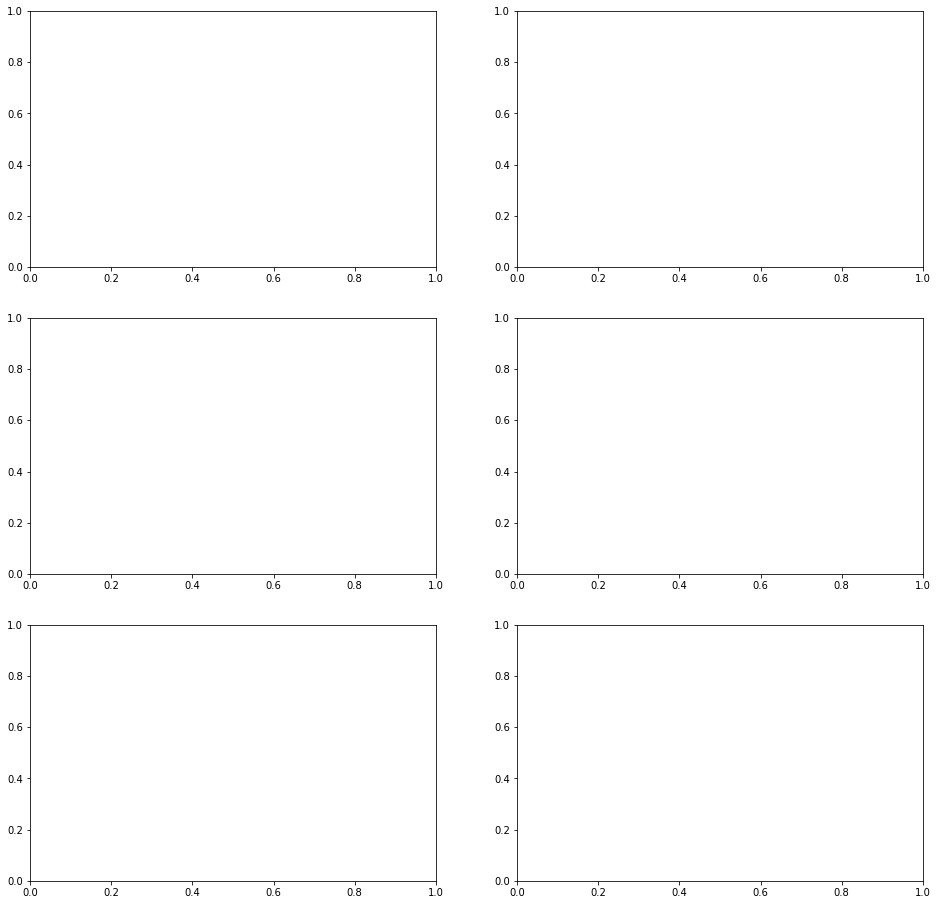

In [516]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

Calculamos los errores.

In [355]:
error_reg = utils.calculate_error(fcst, test)

In [356]:
mae_reg = error_reg.abs().mean()
mae_reg

16061    26.529938
16070    35.042257
16071    24.323758
44146    15.620693
44149    19.804124
44152    11.507714
dtype: float64

In [357]:
mape_reg = mae_reg / test.mean()
mape_reg

16061    0.547782
16070    0.473566
16071    0.611578
44146    0.524256
44149    0.532137
44152    0.554174
dtype: float64

In [358]:
mae_reg.mean()

22.13808067669728

In [359]:
mape_reg.mean()

0.5405822974869393

No hay ninguna mejora respecto al caso sin regresor.

### Con feriados

Se le puede pasar manualmente al modelo una lista de feriados para que use como regresores. También existe la opción de usar una lista predefinida por Prophet. Para este ejemplo usamos la segunda opción.

In [360]:
model = ProphetForecaster(country_holidays="AR", yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


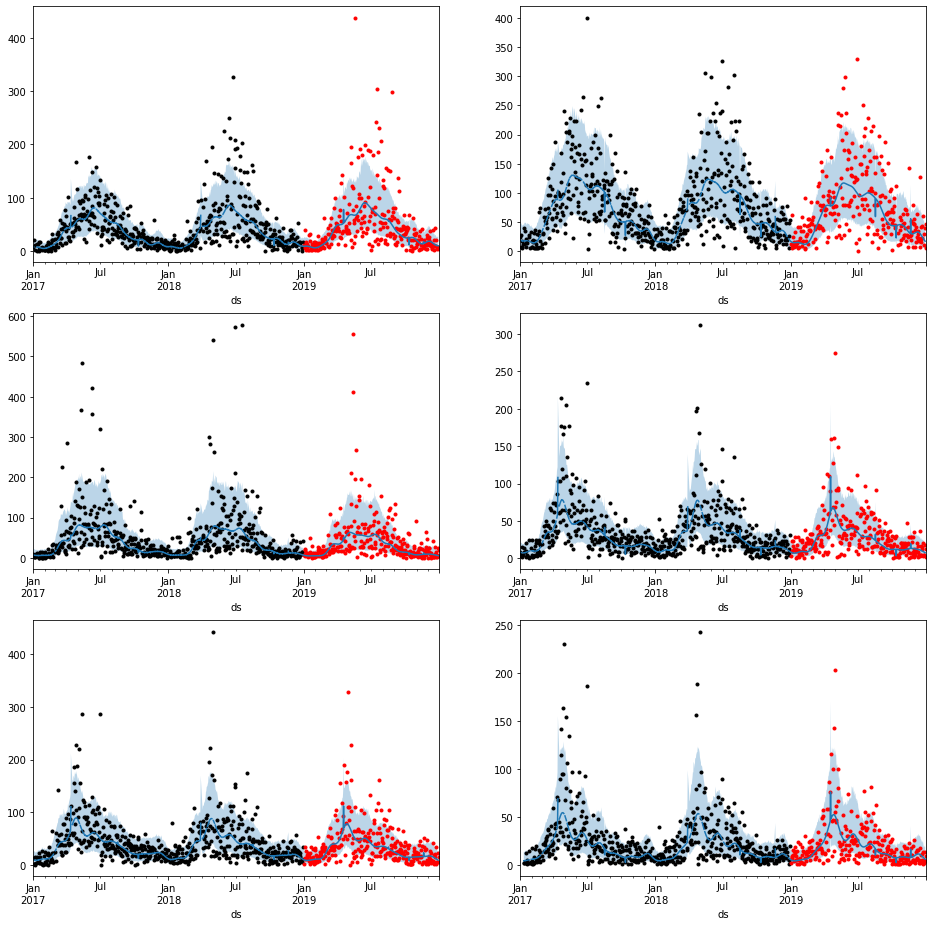

In [361]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [362]:
error_hol = utils.calculate_error(fcst, test)

In [363]:
mae_hol = error_hol.abs().mean()
mae_hol

16061    26.535045
16070    34.453734
16071    23.818956
44146    15.251901
44149    19.415214
44152    11.507173
dtype: float64

In [364]:
mape_hol = mae_hol / test.mean()
mape_hol

16061    0.547887
16070    0.465613
16071    0.598886
44146    0.511879
44149    0.521687
44152    0.554148
dtype: float64

In [365]:
mae_hol.mean()

21.830336999080444

In [366]:
mape_hol.mean()

0.5333500183512294

El resultado es levemente mejor que si no se usaran los feriados, pero no lo suficientemente significativo.

## Pronóstico Semanal

Los pedidos diarios presentan una variabilidad demasiado grande en ciertas épocas del año, generando mucha incertidumbre en el pronóstico. Como alternativa se puede considerar el total de pedidos por semana, obteniendo series con un mejor comportamiento.

In [519]:
train = train_orig.resample("W", closed="left").sum()
test = test_orig.resample("W", closed="left").sum()

In [520]:
train.head()

producto,44152,16061,16070,44146,16071,44149
2017-01-08,0.0,43.0,91.0,32.0,22.0,38.0
2017-01-15,7.0,27.0,100.0,34.0,45.0,46.0
2017-01-22,23.0,47.0,74.0,39.0,34.0,55.0
2017-01-29,19.0,15.0,57.0,28.0,23.0,31.0
2017-02-05,27.0,25.0,85.0,47.0,29.0,55.0


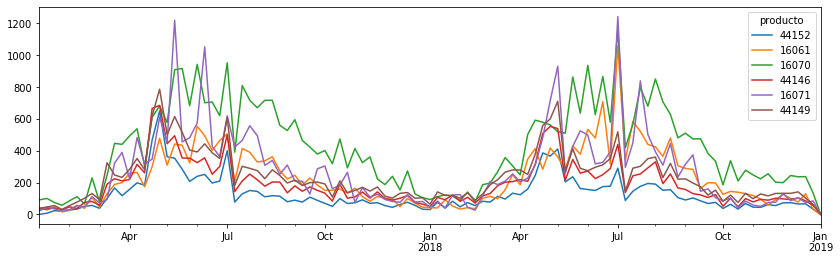

In [521]:
train.plot()

In [522]:
train[train == 0] = np.nan

Ahora ajustamos el modelo para hacer pronósticos con frecuencia semanal, 52 pasos hacia adelante.

In [523]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=52, freq="W").asfreq("W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


1 of 6|###########                                                        | 16%

KeyboardInterrupt: 

In [372]:
fcst.head()

16061                             16070             \
                 yhat yhat_lower yhat_upper        yhat yhat_lower   
ds                                                                   
2017-01-08  37.217074  21.668049  62.110083   99.057937  55.072404   
2017-01-15  39.405668  23.008825  63.345972   88.611670  48.143896   
2017-01-22  36.923241  20.891103  61.119397   93.967942  50.934704   
2017-01-29  31.616602  17.916444  52.173617  100.742988  58.714388   
2017-02-05  29.723825  16.602660  47.833280   99.013034  56.292272   

                            16071                            44146             \
            yhat_upper       yhat yhat_lower yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  153.582313  44.064672  23.496281  83.311528  40.780695  27.677153   
2017-01-15  143.223895  41.842868  22.414402  75.908405  42.152920  29.866147   
2017-01-22  148.297702  45.921813  25.064248  80.587761  48.850651  34.398503   
2017-01-29  159.129160  49.776153  26.277079  88.863834  55.795280  39.750107   
2017-02-05  147.796688  48.913947  26.906060  83.823298  57.312428  40.371429   

                           44149                             44152             \
           yhat_upper       yhat yhat_lower  yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  58.388955  56.271073  39.321211   79.833333        NaN        NaN   
2017-01-15  61.083078  56.962274  40.317121   81.305968  19.491082  13.060817   
2017-01-22  71.201476  63.329898  42.632247   89.599973  23.848156  15.906379   
2017-01-29  80.222598  69.814315  46.909971   97.474811  31.258629  20.866363   
2017-02-05  81.594630  72.790680  49.687632  101.124018  37.620622  24.799975   

                       
           yhat_upper  
ds                     
2017-01-08        NaN  
2017-01-15  29.695345  
2017-01-22  35.765836  
2017-01-29  46.183489  
2017-02-05  53.975834

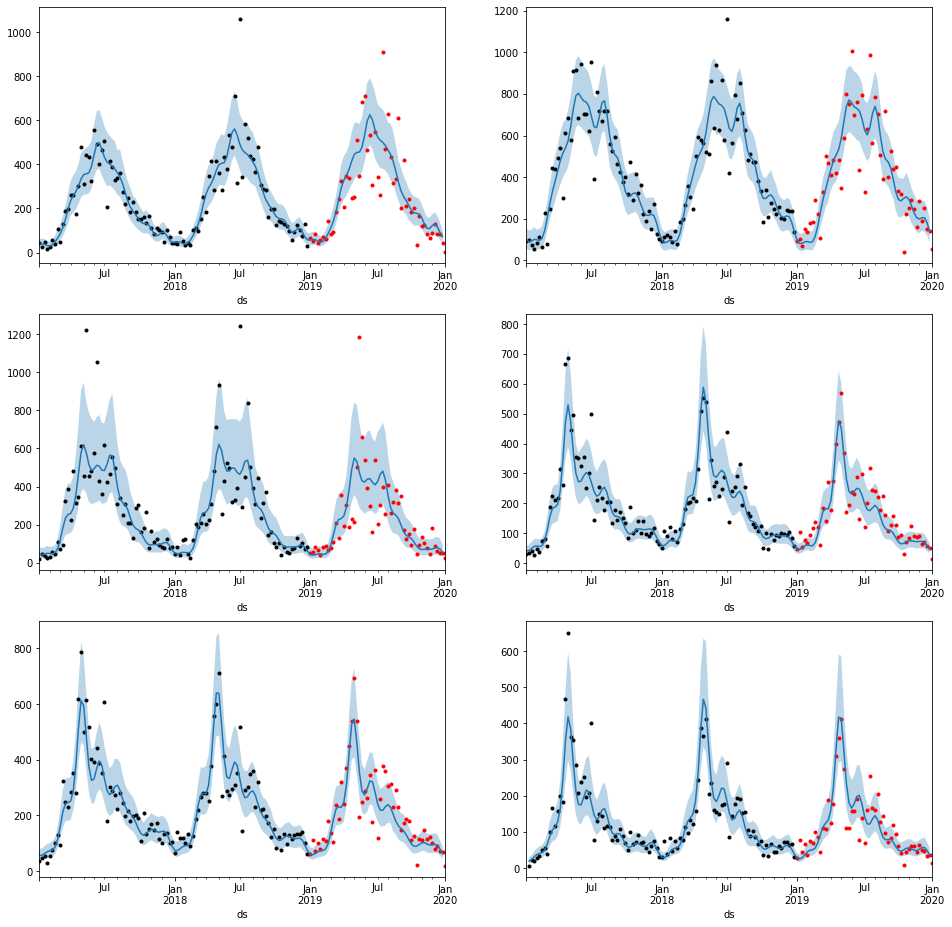

In [373]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

Según las gráficas, el pronóstico se ajusta mejor y tiene más certeza que antes. Podemos verificarlo calculando el error.

In [374]:
error_w = utils.calculate_error(fcst, test)

In [375]:
mae_w = error_w.abs().mean()
mae_w

16061    76.611663
16070    88.668436
16071    89.065099
44146    37.015524
44149    49.374722
44152    31.145868
dtype: float64

In [376]:
mape_w = mae_w / test.mean()
mape_w

16061    0.294169
16070    0.222059
16071    0.403699
44146    0.223952
44149    0.237551
44152    0.274117
dtype: float64

In [377]:
mae_w.mean()

61.98021855379114

In [378]:
mape_w.mean()

0.27592444557453194

Las métricas corroboran que un pronóstico semanal es mejor candidato que uno diario.

A continuación probamos de usar regresores y feriados, al igual que se hizo con el caso diario.

### Con regresores

In [388]:
indicador = indicador_orig.resample("W", closed="left").mean()

In [389]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train, indicador)
fcst = model.predict(steps=52, freq="W", regressors=indicador).asfreq("W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


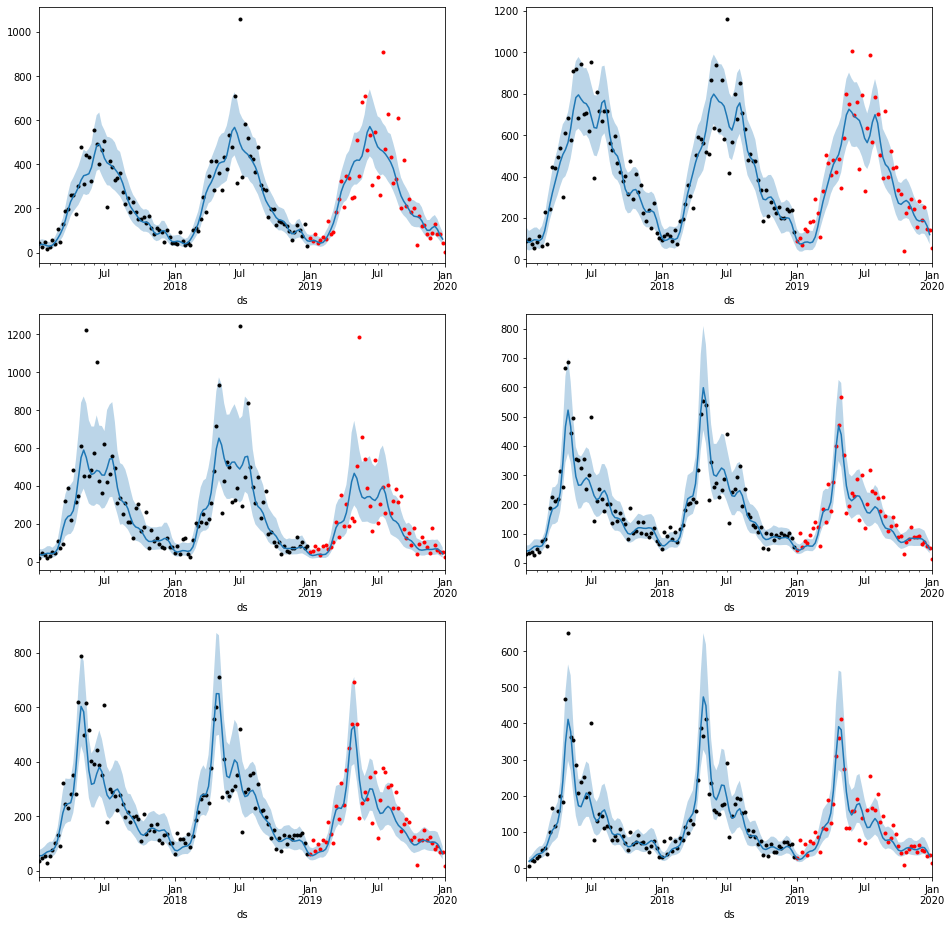

In [390]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [391]:
error_w_reg = utils.calculate_error(fcst, test)

In [392]:
mae_w_reg = error_w_reg.abs().mean()
mae_w_reg

16061    73.431749
16070    91.768705
16071    87.783777
44146    36.690911
44149    48.968597
44152    29.240496
dtype: float64

In [393]:
mape_w_reg = mae_w_reg / test.mean()
mape_w_reg

16061    0.281959
16070    0.229823
16071    0.397891
44146    0.221988
44149    0.235597
44152    0.257347
dtype: float64

In [394]:
mae_w_reg.mean()

61.31403917018756

In [395]:
mape_w_reg.mean()

0.27076764388659486

Con el regresor esta vez se observa una leve mejora, pero sigue sin ser significativa.

### Con feriados

In [451]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True, country_holidays="AR")
model.fit(train)
fcst = model.predict(steps=52, freq="W").asfreq("W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [452]:
fcst.head()

16061                             16070             \
                 yhat yhat_lower yhat_upper        yhat yhat_lower   
ds                                                                   
2017-01-08  39.365004  24.586458  60.310763  103.793016  63.133146   
2017-01-15  40.503937  25.078235  60.705186   91.060099  53.961473   
2017-01-22  37.152947  23.257825  57.107187   94.585139  57.233123   
2017-01-29  31.993502  19.508929  48.728982  101.479365  62.288494   
2017-02-05  30.826487  17.934568  47.514426  101.676945  65.812612   

                            16071                            44146             \
            yhat_upper       yhat yhat_lower yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  152.695757  42.507676  23.592729  71.212021  40.943607  28.675008   
2017-01-15  138.975491  41.119887  22.432411  73.134540  42.283122  28.778505   
2017-01-22  140.599517  44.989154  24.999043  77.265657  48.773287  35.586505   
2017-01-29  151.084264  47.937942  25.591069  83.206314  55.606254  39.758714   
2017-02-05  153.724647  46.907078  26.281245  79.867213  57.336564  40.854232   

                           44149                             44152             \
           yhat_upper       yhat yhat_lower  yhat_upper       yhat yhat_lower   
ds                                                                              
2017-01-08  56.986415  56.618572  39.876274   79.767771        NaN        NaN   
2017-01-15  59.357035  57.347622  40.344649   82.016286  19.804649  12.927779   
2017-01-22  68.510930  63.528922  44.281482   86.990164  24.010762  16.395917   
2017-01-29  78.897261  69.898814  50.528531   96.313188  31.414595  21.565866   
2017-02-05  78.687736  73.085383  51.797095  101.879479  38.008497  26.079299   

                       
           yhat_upper  
ds                     
2017-01-08        NaN  
2017-01-15  29.006320  
2017-01-22  36.157059  
2017-01-29  44.250869  
2017-02-05  56.003757

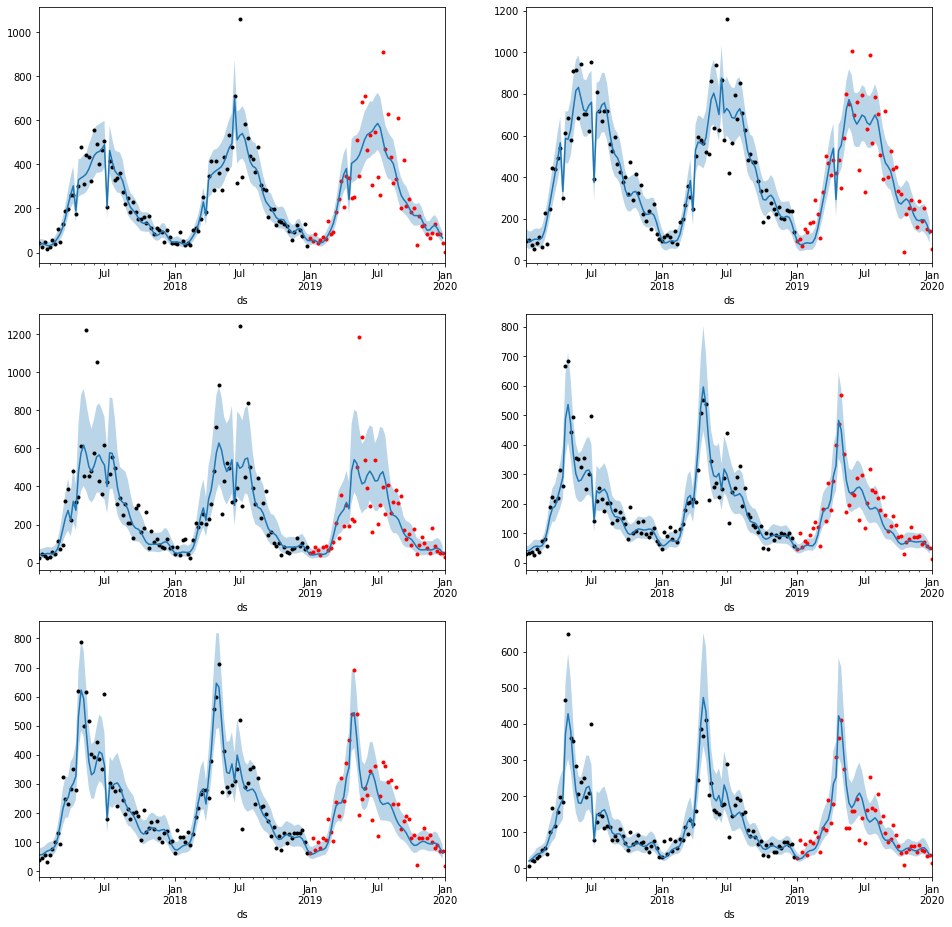

In [453]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [459]:
error_w_hol = utils.calculate_error(fcst, test)

In [460]:
mae_w_hol = error_w_hol.abs().mean()
mae_w_hol

16061    76.723325
16070    92.751029
16071    89.707150
44146    38.820780
44149    49.726462
44152    32.688941
dtype: float64

In [461]:
mape_w_hol = mae_w_hol / test.mean()
mape_w_hol

16061    0.294598
16070    0.232283
16071    0.406609
44146    0.234875
44149    0.239243
44152    0.287697
dtype: float64

In [462]:
mae_w_hol.mean()

63.40294795529612

In [463]:
mape_w_hol.mean()

0.2825508530987506

Esta vez el resultado es peor con los feriados.

Pareciera que no es realmente necesario usar el precio de la nafta o los feriados como regresores, ya que no producen ninguna mejora significativa, tanto en el caso diario como en el caso semanal.

## Pronóstico bisemanal

La metodología es la misma que la usada anteriormente.

In [396]:
train = train_orig.resample("2W", closed="left").sum()
test = test_orig.resample("2W", closed="left").sum()

In [397]:
train.head()

producto,44152,16061,16070,44146,16071,44149
2017-01-15,7.0,70.0,191.0,66.0,67.0,84.0
2017-01-29,42.0,62.0,131.0,67.0,57.0,86.0
2017-02-12,60.0,82.0,196.0,84.0,83.0,132.0
2017-02-26,106.0,144.0,294.0,156.0,158.0,232.0
2017-03-12,138.0,176.0,322.0,246.0,164.0,417.0


In [398]:
train[train == 0] = np.nan

In [399]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=26, freq="2W").asfreq("2W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


In [400]:
fcst.head()

16061                               16070              \
                  yhat  yhat_lower  yhat_upper        yhat  yhat_lower   
ds                                                                       
2017-01-15   77.601077   59.933254   98.618608  188.934850  143.051078   
2017-01-29   74.889317   58.150502   96.867141  193.190338  143.441584   
2017-02-12   79.298256   62.145436  100.156531  223.258315  171.320214   
2017-02-26  117.450705   93.323847  145.830566  271.352808  208.836815   
2017-03-12  194.846241  161.302122  235.190912  450.993822  372.327820   

                             16071                               44146  \
            yhat_upper        yhat  yhat_lower  yhat_upper        yhat   
ds                                                                       
2017-01-15  242.589438   86.349225   55.785747  129.545518   85.739643   
2017-01-29  246.353206   90.452060   57.754526  137.341228  104.455708   
2017-02-12  286.577494  115.226599   76.381180  171.591488  113.276877   
2017-02-26  344.879143  138.159289   91.100471  203.981008  144.347823   
2017-03-12  547.928235  275.280514  191.090100  394.587622  274.417366   

                                         44149                          \
            yhat_lower  yhat_upper        yhat  yhat_lower  yhat_upper   
ds                                                                       
2017-01-15   65.591509  110.574556  111.781607   85.728042  140.218457   
2017-01-29   80.218477  132.858516  137.049658  108.163952  175.122585   
2017-02-12   88.515473  145.392910  153.540675  122.008314  192.949206   
2017-02-26  112.308868  183.900388  211.929020  167.803800  261.111793   
2017-03-12  218.757826  342.250340  394.447216  320.978539  490.840336   

                 44152                          
                  yhat  yhat_lower  yhat_upper  
ds                                              
2017-01-15   31.300245   18.310078   50.492565  
2017-01-29   58.901338   37.174905   87.991330  
2017-02-12   86.478974   57.852324  123.853087  
2017-02-26   98.325752   66.611140  142.985216  
2017-03-12  168.517780  120.782544  232.596804

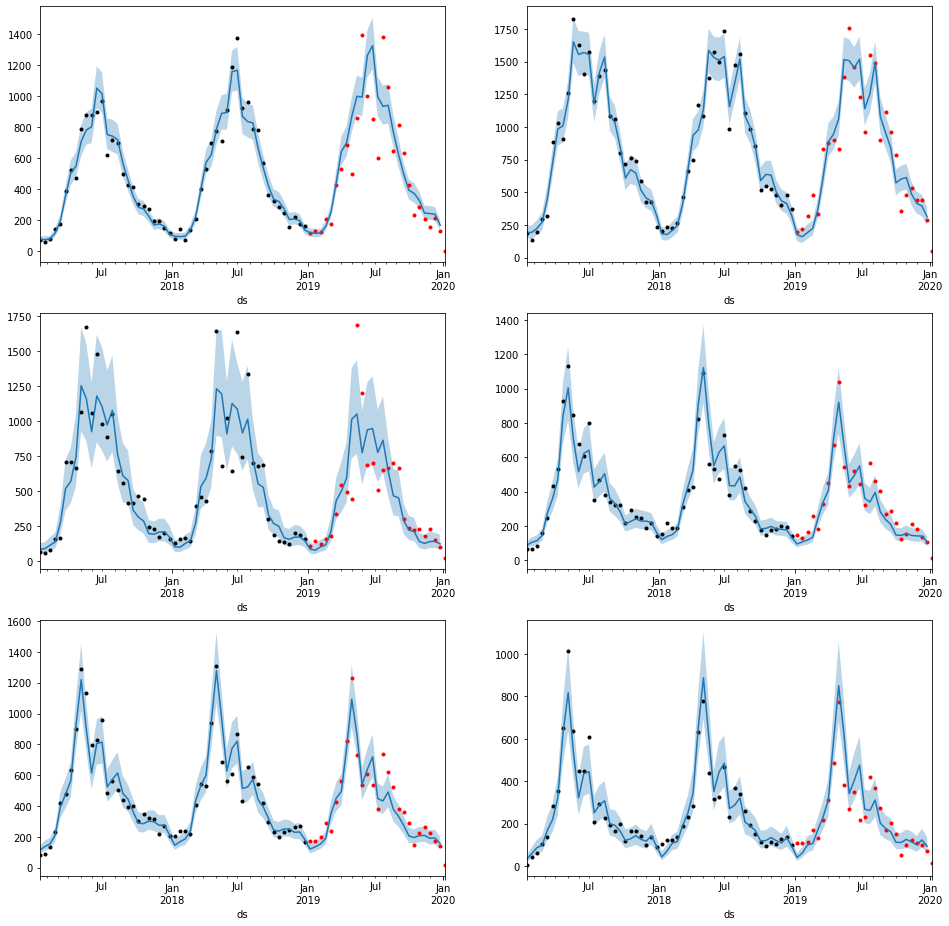

In [401]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [402]:
error_2w = utils.calculate_error(fcst, test)

In [403]:
mae_2w = error_2w.abs().mean()
mae_2w

16061    143.219622
16070    129.017376
16071    145.383331
44146     59.827187
44149     78.051600
44152     61.969942
dtype: float64

In [404]:
mape_2w = mae_2w / test.mean()
mape_2w

16061    0.280151
16070    0.164602
16071    0.335701
44146    0.184399
44149    0.191303
44152    0.277846
dtype: float64

In [405]:
mae_2w.mean()

102.9115097034278

In [406]:
mape_2w.mean()

0.23900031311307726

El ajuste es mejor que en el caso diario y semanal.

### Con regresores

In [410]:
indicador = indicador_orig.resample("2W", closed="left").mean()

In [414]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=26, freq="2W", regressors=indicador).asfreq("2W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


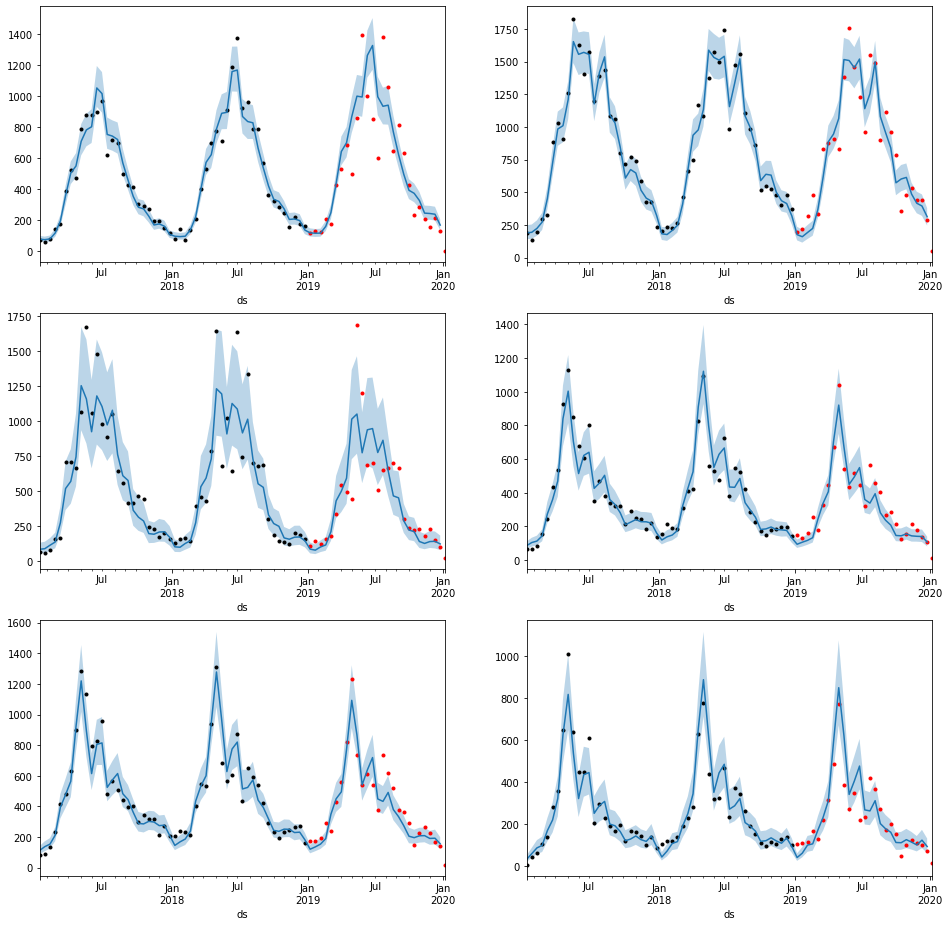

In [416]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [422]:
error_2w_reg = utils.calculate_error(fcst, test)

In [423]:
mae_2w_reg = error_2w_reg.abs().mean()
mae_2w_reg

16061    143.219622
16070    129.017376
16071    145.383331
44146     59.827187
44149     78.051600
44152     61.969942
dtype: float64

In [424]:
mape_2w_reg = mae_2w_reg / test.mean()
mape_2w_reg

16061    0.280151
16070    0.164602
16071    0.335701
44146    0.184399
44149    0.191303
44152    0.277846
dtype: float64

In [425]:
mae_2w_reg.mean()

102.9115097034278

In [426]:
mape_2w_reg.mean()

0.23900031311307726

### Con feriados

In [431]:
model = ProphetForecaster(use_boxcox=True, yearly_seasonality=True, country_holidays="AR")
model.fit(train)
fcst = model.predict(steps=26, freq="2W").asfreq("2W")

Fitting...


6 of 6|###################################################################|100%


Forecasting...


6 of 6|###################################################################|100%


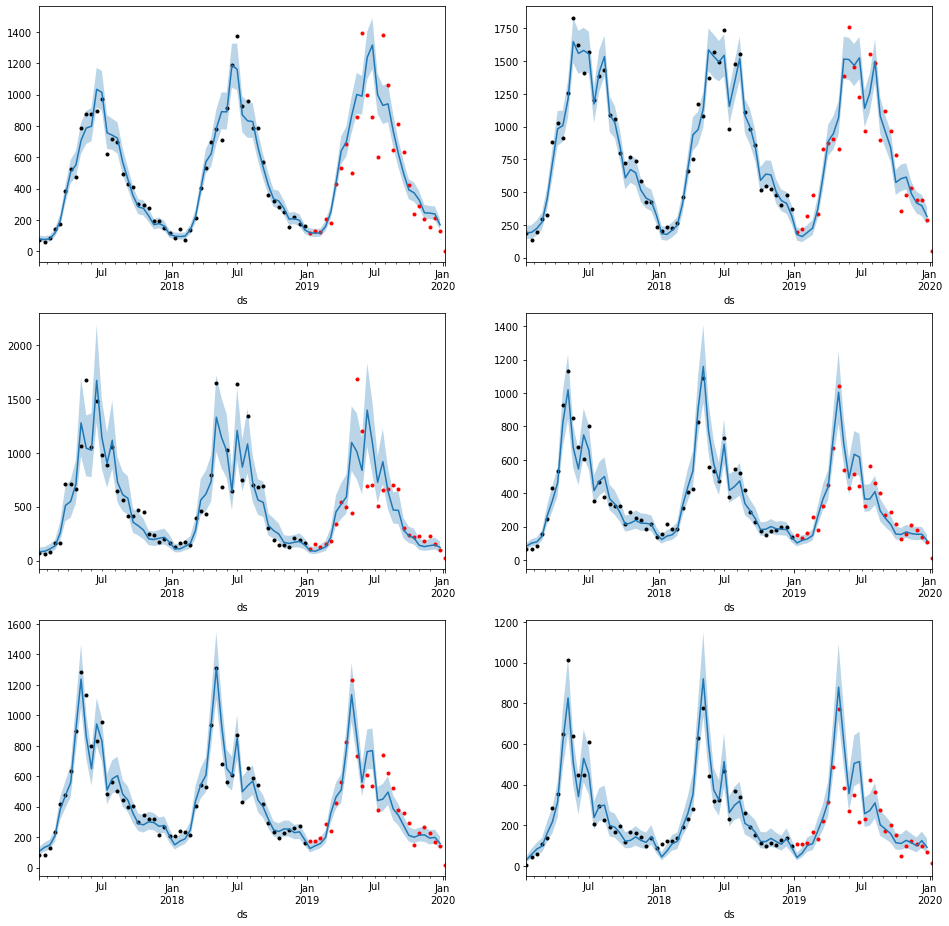

In [433]:
f, axs = plt.subplots(3, 2, figsize=(16,16))
items = fcst.columns.get_level_values(0).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [439]:
error_2w_hol = utils.calculate_error(fcst, test)

In [440]:
mae_2w_hol = error_2w_hol.abs().mean()
mae_2w_hol

16061    142.074209
16070    129.121626
16071    169.768146
44146     62.981647
44149     80.253342
44152     67.692150
dtype: float64

In [441]:
mape_2w_hol = mae_2w_hol / test.mean()
mape_2w_hol

16061    0.277911
16070    0.164735
16071    0.392007
44146    0.194122
44149    0.196699
44152    0.303502
dtype: float64

In [442]:
mae_2w_hol.mean()

108.64851997425608

In [443]:
mape_2w_hol.mean()

0.25482927038349656

# Pronóstico por producto y región

Es posible hacer pronósticos agrupados. Para este ejemplo vamos a hacer un pronóstico por producto y región, por lo que creamos la tabla a partir de los datos originales, con las respectivas series.

In [464]:
u_producto_region = pd.pivot_table(
    data, 
    values="u pedidas", 
    index="tiempo", 
    columns=["producto", "sucursal"], 
    aggfunc="sum").asfreq("D")

In [465]:
u_producto_region = u_producto_region.reindex(index=pd.date_range(start="2017-01-01", end="2019-12-31", freq="D"))

In [466]:
u_producto_region.head()

producto      16034   16061            16062            16070           \
sucursal   santa fe neuquen santa fe neuquen santa fe neuquen santa fe   
2017-01-01      NaN     NaN      NaN     NaN      NaN     NaN      NaN   
2017-01-02      NaN     NaN      7.0     NaN      1.0     NaN     25.0   
2017-01-03      NaN     NaN     21.0     NaN      NaN     NaN     27.0   
2017-01-04      NaN     NaN      NaN     NaN      NaN     NaN      8.0   
2017-01-05      NaN     NaN      3.0     NaN      NaN     NaN      6.0   

producto     16071            16075  ...   44158            90739           \
sucursal   neuquen santa fe neuquen  ... neuquen santa fe neuquen santa fe   
2017-01-01     NaN      NaN     NaN  ...     NaN      NaN     NaN      NaN   
2017-01-02     NaN     11.0     NaN  ...     NaN      NaN     NaN      4.0   
2017-01-03     NaN      2.0     NaN  ...     NaN      NaN     NaN      3.0   
2017-01-04     NaN      4.0     NaN  ...     NaN      1.0     NaN      NaN   
2017-01-05     NaN      3.0     NaN  ...     NaN      1.0     NaN      NaN   

producto     90740            90745            90746           
sucursal   neuquen santa fe neuquen santa fe neuquen santa fe  
2017-01-01     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-02     NaN      1.0     NaN      NaN     NaN      NaN  
2017-01-03     NaN      2.0     NaN      NaN     NaN      NaN  
2017-01-04     NaN      NaN     NaN      NaN     NaN      NaN  
2017-01-05     NaN      1.0     NaN      NaN     NaN      NaN  

[5 rows x 120 columns]

Graficamos la información contenida en cada serie.

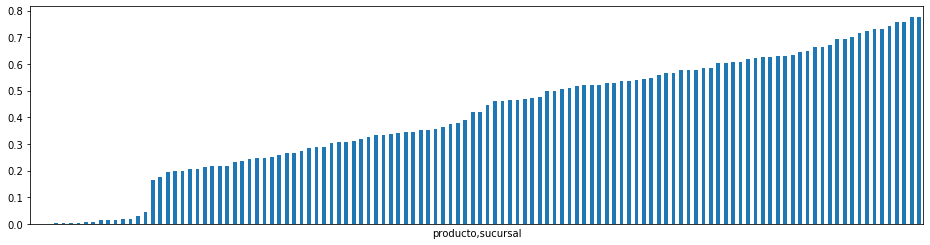

In [467]:
utils.get_amount_info(u_producto_region).plot(kind="bar", figsize=(16,4))
plt.xticks(ticks=[]);

Nos quedamos con 12 series que superan el umbral de 0.5.

In [468]:
u_producto_region_forecastable = utils.get_forecastables(u_producto_region, T=0.5, N=12).sort_index(axis=1)

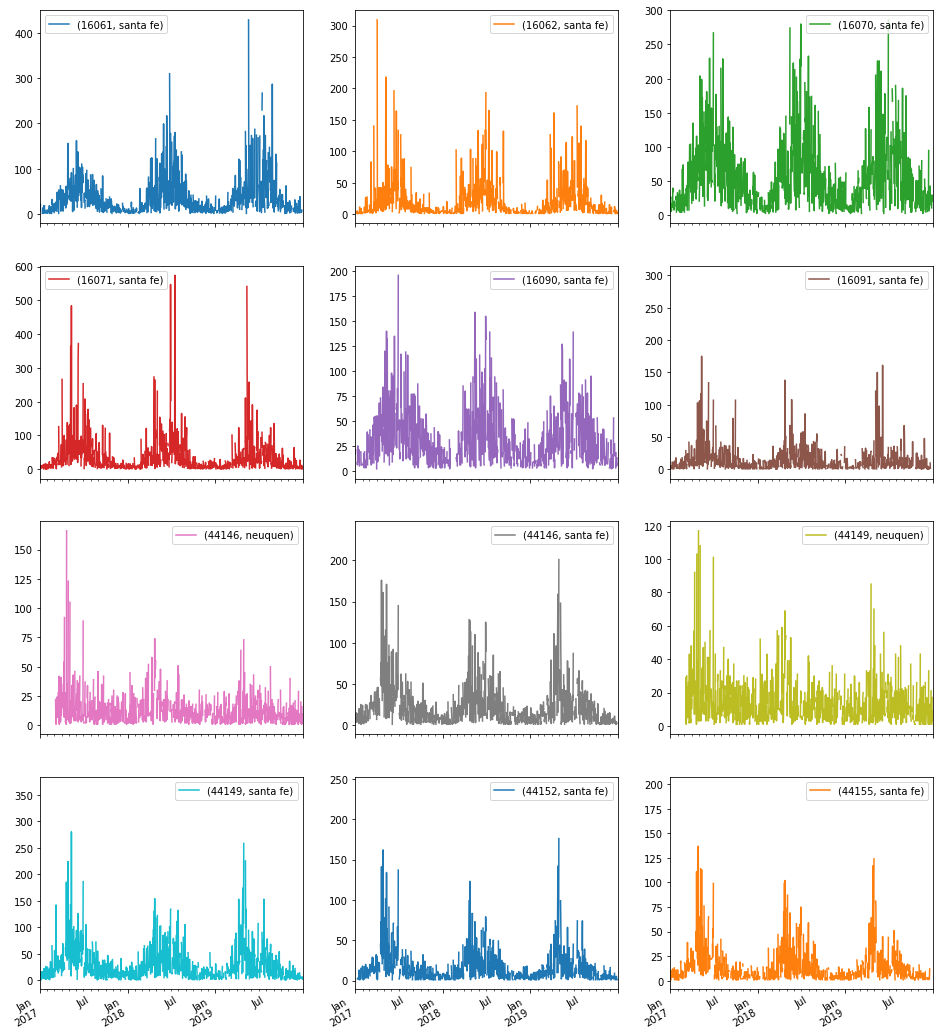

In [469]:
utils.plot_grid(u_producto_region_forecastable, n_cols=3, figsize=(16, 20))

In [477]:
train_orig, test_orig = u_producto_region_forecastable[:"2018-12-31"], u_producto_region_forecastable["2019-01-01":]

## Pronóstico diario

In [495]:
train = train_orig.copy()
test = test_orig.copy()

In [496]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=365).asfreq("D")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [497]:
fcst.head(10)

16061                           16062                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  5.386853   1.670065  16.935038  2.229475   0.746073   7.220748   
2017-01-03  5.406998   1.537410  15.065371       NaN        NaN        NaN   
2017-01-04       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-05  5.441283   1.596328  16.549595       NaN        NaN        NaN   
2017-01-06       NaN        NaN        NaN  2.306941   0.778068   7.338176   
2017-01-07  5.456751   1.450308  16.244286       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN  2.358351   0.717982   7.518991   
2017-01-10       NaN        NaN        NaN  2.370805   0.775413   7.788422   
2017-01-11  5.395641   1.433017  15.549713  2.379988   0.808781   7.389862   

                16070                           16071  ...      44149  \
             santa fe                        santa fe  ...    neuquen   
                 yhat yhat_lower yhat_upper      yhat  ... yhat_upper   
ds                                                     ...              
2017-01-02  14.953977   4.131406  41.725148  5.567765  ...        NaN   
2017-01-03  14.656313   4.702902  39.560691  5.496262  ...        NaN   
2017-01-04  14.414836   4.613350  39.159996  5.432328  ...        NaN   
2017-01-05  14.227067   4.189576  38.322650  5.375307  ...        NaN   
2017-01-06  14.089813   4.229136  40.495064       NaN  ...        NaN   
2017-01-07  13.999225   4.215635  37.635541  5.279075  ...        NaN   
2017-01-08        NaN        NaN        NaN       NaN  ...        NaN   
2017-01-09        NaN        NaN        NaN  5.201425  ...        NaN   
2017-01-10  13.960102   4.082797  37.541311  5.167639  ...        NaN   
2017-01-11  14.006174   3.960860  36.204223  5.136246  ...        NaN   

                                               44152                        \
            santa fe                        santa fe                         
                yhat yhat_lower yhat_upper      yhat yhat_lower yhat_upper   
ds                                                                           
2017-01-02  7.859500   1.929941  24.476286       NaN        NaN        NaN   
2017-01-03  7.707466   1.893666  25.862422       NaN        NaN        NaN   
2017-01-04  7.570713   2.008835  22.915488       NaN        NaN        NaN   
2017-01-05  7.449867   1.778374  23.607467       NaN        NaN        NaN   
2017-01-06  7.345328   1.847968  22.844806       NaN        NaN        NaN   
2017-01-07  7.257265   1.927780  22.810259       NaN        NaN        NaN   
2017-01-08       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-09       NaN        NaN        NaN       NaN        NaN        NaN   
2017-01-10  7.090192   1.723448  22.761552       NaN        NaN        NaN   
2017-01-11  7.065153   1.783471  23.379048  3.503355   1.082425  11.204197   

               44155                        
            santa fe                        
                yhat yhat_lower yhat_upper  
ds                                          
2017-01-02  3.829905   1.250009  12.196536  
2017-01-03       NaN        NaN        NaN  
2017-01-04  3.911377   1.356889  11.367460  
2017-01-05  3.942978   1.263569  11.802553  
2017-01-06       NaN        NaN        NaN  
2017-01-07  3.979607   1.364769  12.431295  
2017-01-08       NaN        NaN        NaN  
2017-01-09       NaN        NaN        NaN  
2017-01-10  3.954297   1.397167  12.373460  
2017-01-11  3.923883   1.314639  11.212644  

[10 rows x 36 columns]

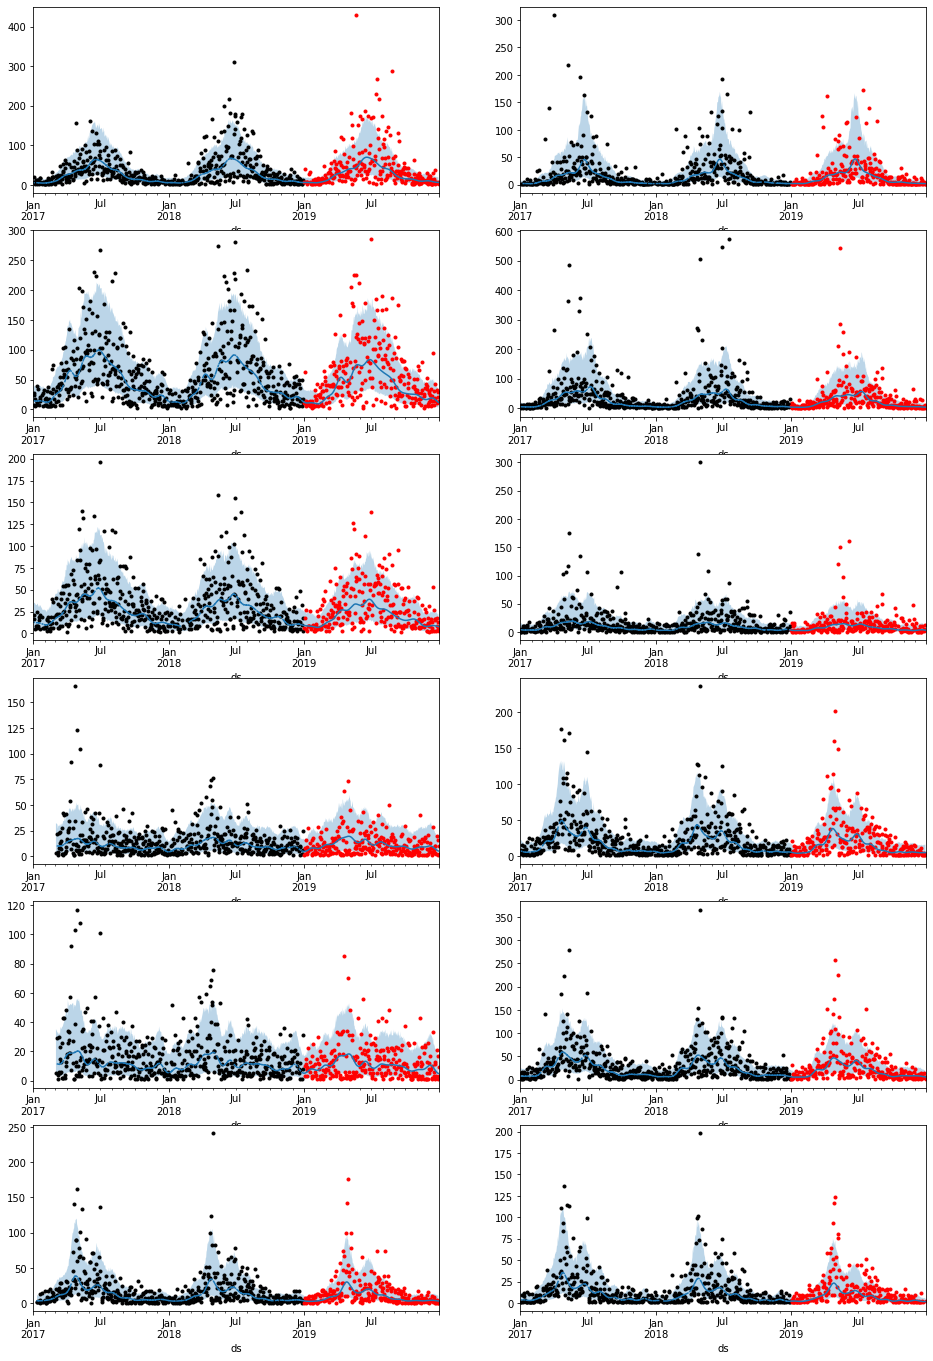

In [498]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

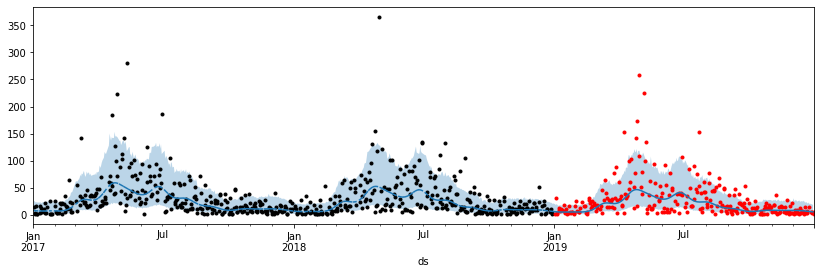

In [499]:
item = (44149, "santa fe")
utils.plot_fcst(fcst[item], train[item], test[item])

In [500]:
error2 = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :,"yhat"]].droplevel(2, axis=1) - test
mae2 = error2.abs().mean()
mae2

16061  santa fe    25.558465
16062  santa fe    12.729719
16070  santa fe    29.831057
16071  santa fe    21.205558
16090  santa fe    16.159134
16091  santa fe     9.290050
44146  neuquen      7.612806
       santa fe    13.220995
44149  neuquen      8.371939
       santa fe    16.696083
44152  santa fe     9.854637
44155  santa fe     8.601494
dtype: float64

In [504]:
mape2 = mae2 / test.mean()
mape2

16061  santa fe    0.610620
16062  santa fe    0.664553
16070  santa fe    0.539929
16071  santa fe    0.663556
16090  santa fe    0.558593
16091  santa fe    0.695791
44146  neuquen     0.666833
       santa fe    0.636764
44149  neuquen     0.655385
       santa fe    0.622214
44152  santa fe    0.638972
44155  santa fe    0.631185
dtype: float64

In [502]:
mae2.mean()

14.927661483012391

In [503]:
mape2.mean()

0.6320329700821393

## Pronóstico Semanal

In [483]:
train = train_orig.resample("W", closed="left").sum()
test = test_orig.resample("W", closed="left").sum()

In [484]:
train[train == 0] = np.nan

In [485]:
model = ProphetForecaster(yearly_seasonality=True)
model.fit(train)
fcst = model.predict(steps=52, freq="W").asfreq("W")

Fitting...


12 of 12|#################################################################|100%


Forecasting...


12 of 12|#################################################################|100%


In [486]:
fcst.head(10)

16061                             16062             \
             santa fe                          santa fe              
                 yhat yhat_lower  yhat_upper       yhat yhat_lower   
ds                                                                   
2017-01-08  28.737316  17.499736   46.277580   7.147390   3.277889   
2017-01-15  29.383838  17.952583   45.790176  11.009872   5.071039   
2017-01-22  26.754222  16.233305   41.971685  16.096677   7.643030   
2017-01-29  22.986237  14.118076   37.418821  16.262881   7.954835   
2017-02-05  22.511850  13.348932   37.529682  13.202090   6.318330   
2017-02-12  27.760216  16.991501   44.724530  13.297726   6.278800   
2017-02-19  38.670791  24.186823   60.740097  20.351978  10.117809   
2017-02-26  51.560481  32.657813   82.593201  36.225313  19.012214   
2017-03-05  63.277434  41.624226   96.673891  53.286476  28.567669   
2017-03-12  77.875179  50.521830  114.456490  62.667585  31.909765   

                             16070                               16071  ...  \
                          santa fe                            santa fe  ...   
            yhat_upper        yhat  yhat_lower  yhat_upper        yhat  ...   
ds                                                                      ...   
2017-01-08   15.330820   79.872895   47.681654  120.958127   34.744823  ...   
2017-01-15   21.190822   69.755474   40.896457  108.578441   33.078678  ...   
2017-01-22   31.799322   68.749193   39.635808  106.304357   34.830568  ...   
2017-01-29   30.139246   68.305400   39.912146  104.687980   35.806089  ...   
2017-02-05   26.125941   66.663715   40.122427  102.789046   34.796665  ...   
2017-02-12   26.379278   70.248828   41.294776  105.790664   35.087332  ...   
2017-02-19   38.988016   86.287100   54.159707  133.151894   41.192957  ...   
2017-02-26   67.295138  115.672658   74.633068  175.982527   57.520012  ...   
2017-03-05   94.711237  148.579453   98.652604  216.254004   87.331421  ...   
2017-03-12  109.058288  174.389446  116.741298  255.475201  126.997807  ...   

                 44149                                          44152  \
               neuquen    santa fe                           santa fe   
            yhat_upper        yhat  yhat_lower  yhat_upper       yhat   
ds                                                                      
2017-01-08         NaN   47.428437   33.271465   67.537356        NaN   
2017-01-15         NaN   47.400816   34.135499   67.929135  15.679476   
2017-01-22         NaN   47.561319   34.053315   66.964608  18.229268   
2017-01-29         NaN   47.776013   34.835068   66.433182  22.672106   
2017-02-05         NaN   50.508649   35.031806   72.901786  27.560892   
2017-02-12         NaN   58.916090   41.819614   84.088447  31.927044   
2017-02-19         NaN   75.435320   52.859461  109.154986  36.601950   
2017-02-26         NaN  100.239416   69.930798  145.019687  43.466501   
2017-03-05   84.114003  129.074404   87.477559  189.318614  53.423445   
2017-03-12  114.315324  153.625647  105.415964  231.139308  64.465937   

                                      44155                        
                                   santa fe                        
           yhat_lower yhat_upper       yhat yhat_lower yhat_upper  
ds                                                                 
2017-01-08        NaN        NaN  17.621967  12.481064  24.577278  
2017-01-15  11.237566  22.923051  16.134479  11.380186  22.271136  
2017-01-22  12.694857  26.886826  16.060772  11.819664  22.109455  
2017-01-29  15.381705  32.976859  18.191021  13.054649  25.303620  
2017-02-05  19.017331  41.169329  23.211742  16.507560  33.802748  
2017-02-12  21.817183  47.189740  30.622220  21.047113  43.734469  
2017-02-19  25.393355  55.823578  37.809419  26.216027  55.893955  
2017-02-26  30.019289  66.438091  43.033943  29.364466  64.504964  
2017-03-05  36.399907  82.449097  48.695650  32.536664  74.551048  
2017-03-12  43.234761

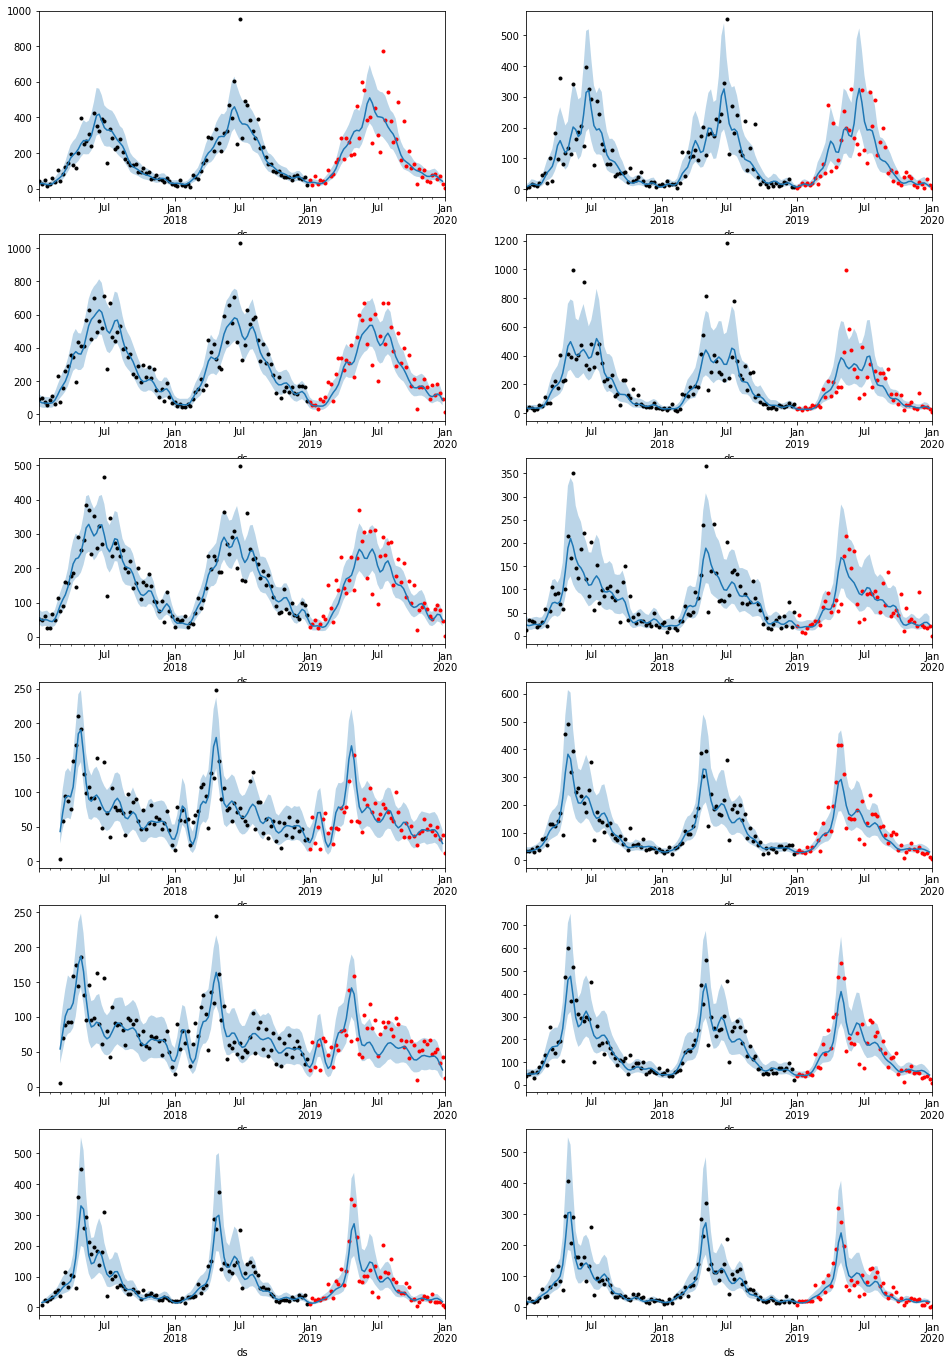

In [487]:
f, axs = plt.subplots(6, 2, figsize=(16,24))
items = fcst.columns.droplevel(2).drop_duplicates()
item_ax = zip(items, np.ravel(axs))
for item, ax in item_ax:
    utils.plot_fcst(fcst[item], train=train[item], test=test[item], ax=ax)

In [490]:
error2_w = fcst.loc["2019-01-01":"2019-12-31", pd.IndexSlice[:, :,"yhat"]].droplevel(2, axis=1) - test
mae2_w = error2_w.abs().mean()
mae2_w

16061  santa fe    68.010121
16062  santa fe    41.045263
16070  santa fe    74.371793
16071  santa fe    74.139526
16090  santa fe    41.933665
16091  santa fe    23.616511
44146  neuquen     18.019114
       santa fe    31.956286
44149  neuquen     21.685335
       santa fe    41.843587
44152  santa fe    24.488106
44155  santa fe    21.648700
dtype: float64

In [493]:
mape2_w = mae2_w / test.mean()
mape2_w

16061  santa fe    0.324967
16062  santa fe    0.430176
16070  santa fe    0.262291
16071  santa fe    0.436018
16090  santa fe    0.289914
16091  santa fe    0.370537
44146  neuquen     0.310978
       santa fe    0.297712
44149  neuquen     0.333234
       santa fe    0.293077
44152  santa fe    0.317560
44155  santa fe    0.340874
dtype: float64

In [491]:
mae2_w.mean()

40.229834062309585

In [494]:
mape2_w.mean()

0.33394481595848885